# Project 3: Natural Language Processing and Classification

Benjamin Chee, DSI-SG-17

Classifying posts from r/xboxone and r/PS5

# Notebook 5: Model Testing, Data Interpretation, Conclusion

This notebook contains code used to test our chosen model, the NMB Model

Relevant word tokens that are interesting are also discussed.

In conclusion, a recommendation to Digital Marketers at Sony is made


## Libraries

In [1]:
import datetime
import time
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

#nlp
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

# general scikitlearn imports
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#NLP
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

# metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score,roc_curve

In [2]:
#initialise date time
date_run = datetime.datetime.now()
date= date_run.date()

In [3]:
#reading output from notebook 1
df_pre=pd.read_csv('./csv/df_pre_2020-10-01.csv')

In [4]:
df_pre.dropna(inplace=True)

In [5]:
X = df_pre['post_lm']
y = df_pre['from_ps5']

In [6]:
# test set produced after the webscrape is done, name is test
test=pd.read_csv('./csv/test.csv')

In [7]:
#treatment for the text is the same as before
test.comb.replace('&amp;','&',inplace=True)
test.comb.replace('#x200B;',' ',inplace=True) # zero width space
test.comb.replace('nbsp;',' ',inplace=True) #non breaking space

In [8]:
rt = RegexpTokenizer(r"[\w/\']+") 

In [9]:
comb_tokens = []  # empty token list

for i in range(len(test.comb)):
    loop_tokens = rt.tokenize(test.comb.at[i].lower())
    for j, token in enumerate(loop_tokens):
        if re.match(r"\d+[\w]*", token):
            loop_tokens[j] = ''
        if re.match(r"//[\w]*", token):
            loop_tokens[j] = ''
        if ('PS5' in token)|('xboxone' in token)|('http' in token):
            loop_tokens[j] = ''
    comb_tokens.append(loop_tokens)   

In [10]:
lm = WordNetLemmatizer()

In [11]:
posts_lm = []

for post in comb_tokens:
    post_st = [] # empty post stems
    for word in post:
        #print(word)
        word_st = lm.lemmatize(word) # get lemmatized word
        post_st.append(word_st) # add to post list
    posts_lm.append(post_st)  # add post list to lemma matrix
    
posts_lm_list = []

for post in posts_lm:
    posts_lm_list.append(' '.join(post))

In [12]:
test_pre = pd.DataFrame(data=[posts_lm_list], index=['post_lm'])
test_pre=test_pre.T

In [13]:
X.isnull().sum()

0

In [14]:
test.fillna(' ',inplace=True)

In [15]:
test.isnull().sum()

title       0
post        0
author      0
from_ps5    0
comb        0
dtype: int64

In [16]:
X_test = test_pre.post_lm
y_test = test['from_ps5']

In [17]:
y_test.isnull().sum()

0

## Model 1 Optimized: Multinomial Naive Bayes

In [18]:
m1_steps = [('m1_cv',CountVectorizer(stop_words='english', ngram_range=(1,1), max_features=3490)),
           ('m1_mnb',MultinomialNB(alpha=1.05))]

In [19]:
pipe_1 = Pipeline(m1_steps)
pipe_1.fit(X, y)


Pipeline(steps=[('m1_cv',
                 CountVectorizer(max_features=3490, stop_words='english')),
                ('m1_mnb', MultinomialNB(alpha=1.05))])

In [20]:
pred_proba = [i[1] for i in pipe_1.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

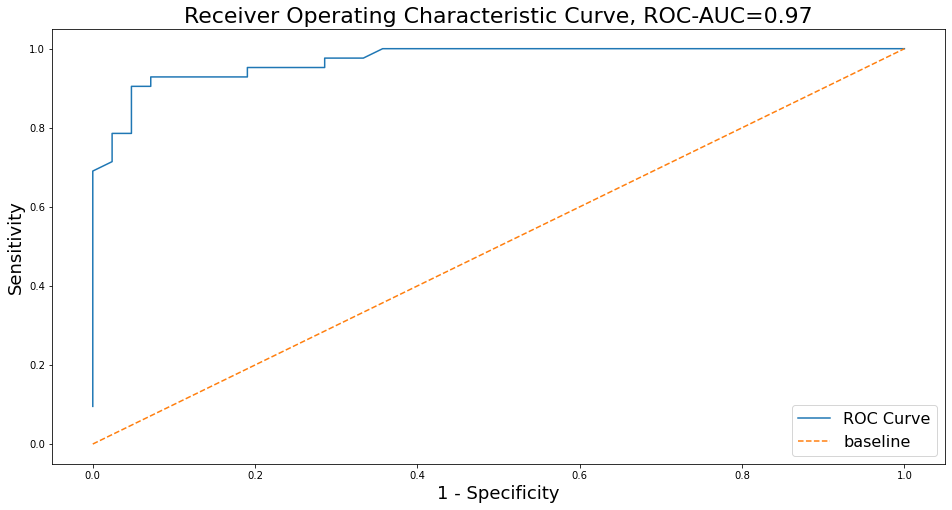

In [21]:
plt.figure(figsize = (16,8))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve, ROC-AUC=0.97', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

In [22]:
roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])

0.9705215419501133

In [23]:
pipe_1.score(X_test, y_test)

0.8928571428571429

In [24]:
tn, fp, fn, tp = confusion_matrix(y_test, pipe_1.predict(X_test)).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

print("\nAccuracy: ", (tn + tp) / (tn + fp + fn + tp))
print("Sensitivity: ", tp / (tp + fn))
print("Specificity: ", tn / (tn + fp))
print("Precision: ", tp / (tp + fp))

True Negatives: 36
False Positives: 6
False Negatives: 3
True Positives: 39

Accuracy:  0.8928571428571429
Sensitivity:  0.9285714285714286
Specificity:  0.8571428571428571
Precision:  0.8666666666666667


As we can see, the accuracy score is around 0.9, which is acceptable. Some overfitting is evident since the train score for this model was closer to 0.97, but this model works as a rough cut.

## Word Features

To achieve the goal of helping provide business value to the digital marketing team, the features must be extracted and compared to 1 another to see if there are any word tokens that stand out

In [26]:
m1 = pipe_1.named_steps['m1_mnb']
cv1 = pipe_1.named_steps['m1_cv']
cv1.fit_transform(X)

<1362x3490 sparse matrix of type '<class 'numpy.int64'>'
	with 28990 stored elements in Compressed Sparse Row format>

In [27]:
m1_df = pd.DataFrame(m1.coef_.T, index=cv1.get_feature_names(), columns=['coef'])

In [28]:
#sorting by smallest coefficient (nore likely ps5)
m1_df.coef.sort_values(ascending=False).head(30)

game          -3.494587
ps5           -3.627333
ps4           -4.452118
like          -4.609364
just          -4.857466
wa            -4.945726
sony          -5.001054
think         -5.077008
new           -5.085815
playstation   -5.131051
time          -5.324447
know          -5.347162
console       -5.370406
don           -5.382233
play          -5.406316
ha            -5.443564
really        -5.508904
launch        -5.564436
want          -5.608206
title         -5.608206
soul          -5.669717
buy           -5.701952
look          -5.718467
ve            -5.735260
day           -5.735260
people        -5.752340
going         -5.787401
man           -5.787401
com           -5.805403
gt            -5.823735
Name: coef, dtype: float64

Many words here are common, non- stopwords that are trivial to us. Others are expected, such as playstation and sony. The most interesting is the last one 'spider'

In [29]:
m1_df.coef.sort_values(ascending=False).tail(30)

squid           -9.764855
squad           -9.764855
spring          -9.764855
gf              -9.764855
giana           -9.764855
girlfriend      -9.764855
gal             -9.764855
fusion          -9.764855
stereo          -9.764855
funimation      -9.764855
forwarding      -9.764855
founder         -9.764855
fpelonm         -9.764855
steamcharts     -9.764855
freak           -9.764855
stealth         -9.764855
freediving      -9.764855
freeks          -9.764855
freesync        -9.764855
freeze          -9.764855
freezing        -9.764855
frequently      -9.764855
stats           -9.764855
statistic       -9.764855
fucked          -9.764855
fullscreen      -9.764855
static          -9.764855
functionality   -9.764855
functioning     -9.764855
zubmariner      -9.764855
Name: coef, dtype: float64

However, it does not seem like the other end is really useful. We have to look at some of our other fitted models for hints

In [35]:
m2_steps = [('m2_tf',TfidfVectorizer(stop_words='english', ngram_range=(1,1))),
           ('m2_rf',RandomForestClassifier(criterion='gini', n_estimators=93, max_depth=8))]

In [38]:
pipe_2 = Pipeline(m2_steps)
pipe_2.fit(X, y)

Pipeline(steps=[('m2_tf', TfidfVectorizer(stop_words='english')),
                ('m2_rf',
                 RandomForestClassifier(max_depth=8, n_estimators=93))])

In [39]:
m2 = pipe_2.named_steps['m2_rf']
cv2 = pipe_2.named_steps['m2_tf']
cv2.fit_transform(X)

<1362x5996 sparse matrix of type '<class 'numpy.float64'>'
	with 31496 stored elements in Compressed Sparse Row format>

In [46]:
m2_df = pd.DataFrame(m2.feature_importances_, index=cv2.get_feature_names(), columns=['fi'])


In [47]:
m2_df.fi.sort_values(ascending=False).head(30)

ps5            0.096590
ps4            0.062850
xbox           0.045629
playstation    0.029420
man            0.028219
sony           0.025686
series         0.020782
spider         0.020585
mile           0.019144
think          0.015421
demon          0.014142
soul           0.011073
lot            0.010318
app            0.009974
gamepass       0.009668
version        0.009245
ps3            0.008758
morale         0.008167
launch         0.008055
far            0.007888
problem        0.007453
plus           0.007226
remake         0.007097
fix            0.007057
spiderman      0.006978
pas            0.006794
live           0.006533
way            0.006196
gold           0.005979
microsoft      0.005716
Name: fi, dtype: float64

Text(0.5, 1.0, 'Top Relative frequency of Word features for classifying to PS5')

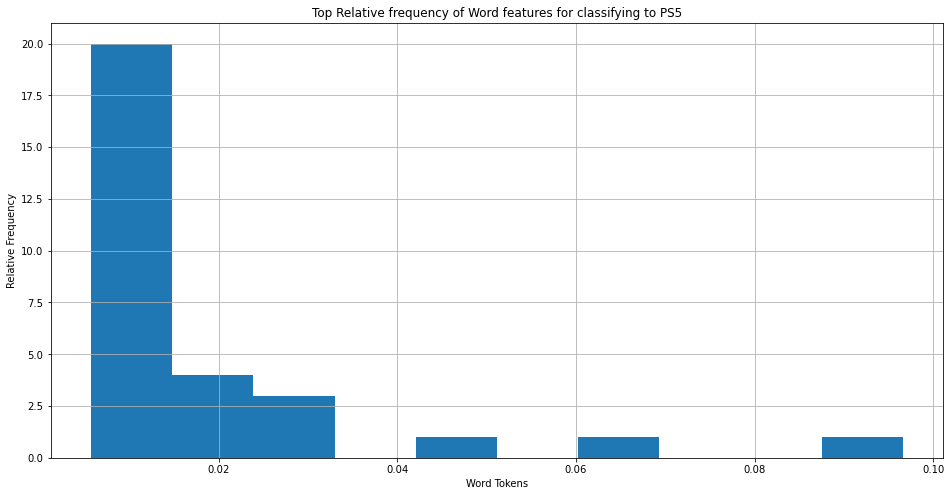

In [60]:
a.hist(figsize =(16,8),label='str')
plt.xlabel('Word Tokens') 
plt.ylabel('Relative Frequency')
plt.title('Top Relative frequency of Word features for classifying to PS5') 

In [59]:

m2_df.fi.sort_values(ascending=False).tail(30)


platinum           0.0
playable           0.0
playhasnolimits    0.0
playlist           0.0
playseat           0.0
playstations       0.0
playtime           0.0
pleased            0.0
plague             0.0
placed             0.0
pin                0.0
place              0.0
ping               0.0
pink               0.0
pinpoint           0.0
pipe               0.0
pipeline           0.0
piracy             0.0
pirate             0.0
pirated            0.0
pit                0.0
pita               0.0
pitched            0.0
pivot              0.0
pivoting           0.0
pixel              0.0
pizza              0.0
pjpg               0.0
pks                0.0
01drxixndyq        0.0
Name: fi, dtype: float64

## Data interpretation:

Looking specifically at the list of features from the Multinomial Naive Bayes model, we see words strongly pointing towards the Playstation line, such as PS4, PS5, and Playstation. However, these are generally considered trivial, since they already point to Sony's own products.


More interesting is the 2nd set of words which pertain to game names. These are namely: Marvel, spider, man, demon, and soul. These words refer very much to 2 Playstation exclusive game series:

- [Spider-man Remastered](https://blog.playstation.com/2020/09/30/marvels-spider-man-remastered-detailed/)
- [Demon Souls](https://www.playstation.com/en-us/games/demons-souls/)


These show that potential buyers for the Playstation are very much interested in the games that are exclusively produced for PS5. It is a strong signal for Sony's marketing team that the strategy to collaborate with game studios to produce titles only for Playstation is an effective strategy


Moreover, since the subreddit is already self-selecting potential buyers, it may make sense to drive PS5 sales by marketing through Reddit. This can take the form of game teasers for those PS5 exclusive games in the week leading up to Black Friday. Adwords on Reddit or Google itself can also be a focus for the digital marketing spend in the period leading up to the product launch in November.

## Conclusion:

Work with the digital marketing team to focus on buying adwords and banner space on Reddit for PS5 exclusive games in the lead up to product launch would be an effective way of driving mindshare.

## Possible extensions:

Continue with further classifications to PC focused subreddits such as r/pcgaming and r/pcmasterrace to see if the above hypothesis also holds true: words related to PS5 exclusive titles should also do well in distinguishing reddit posts into their r/PS5 vis a vis the pc gaming subreddits.